### Try to predict cars/trucks/motorcycle from weather data

In [1]:
# Loading the packages
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split


In [2]:
# Read the dataframe
df_full_data = pd.read_csv('../processed_data/full_data.csv')
print(type(df_full_data['Datum'][1]))  # the 'Datum' column has str-format, not date-format

<class 'str'>


In [3]:
# We have to change the fromat to datetime-format
df_full_data['Datum'] = df_full_data['Datum'].map(lambda x: str(x)[
                                                            :-7])  # in this process we tried to remove '00+0100' and adding '30' to get a good date format working with
df_full_data['Datum'] = df_full_data['Datum'].astype(str) + '30'
df_full_data['Datum'] = pd.to_datetime(df_full_data['Datum'], format="%Y-%m-%dT%H:%M")
print('Format changed to DATE')

Format changed to DATE


In [4]:
#filter columms that we don't need: -> weather is here considered as RainDur and Temperature
df_weather_traffic_hourly=df_full_data[['Datum','Zweirad_schaff','Zweirad_stampf','Personenwagen_schaff','Personenwagen_stampf','Lastwagen_schaff','Lastwagen_stampf','RainDur','T']]
#remove NaN rows
df_weather_traffic_hourly=df_weather_traffic_hourly.dropna()
#combine the two directions of the traffic-flow:
df_weather_traffic_hourly['Zweirad']=df_weather_traffic_hourly['Zweirad_schaff']+df_weather_traffic_hourly['Zweirad_stampf']
df_weather_traffic_hourly['Personenwagen']=df_weather_traffic_hourly['Personenwagen_schaff']+df_weather_traffic_hourly['Personenwagen_stampf']
df_weather_traffic_hourly['Lastwagen']=df_weather_traffic_hourly['Lastwagen_schaff']+df_weather_traffic_hourly['Lastwagen_stampf']
df_weather_traffic_hourly=df_weather_traffic_hourly.drop(columns=['Zweirad_schaff','Zweirad_stampf','Personenwagen_schaff','Personenwagen_stampf','Lastwagen_schaff','Lastwagen_stampf'])
df_weather_traffic_hourly.rename(columns = {'T' : 'Temp'}, inplace = True)

In [5]:
#Now we have hourly values. What we want is daily values!
#RainDur -> Adding all Minutes in a hour to Minutes in a day
#Temperature -> Using the mean temperature
#Zweirad / Personenwagen / Lastwagen -> Adding all together from a day

df_weather_traffic_hourly_index = df_weather_traffic_hourly.set_index('Datum')
#resample all column with sum
df_weather_traffic_daily_1 = df_weather_traffic_hourly_index[['RainDur','Zweirad','Personenwagen','Lastwagen']].resample('D').sum()
df_weather_traffic_daily_2=df_weather_traffic_hourly_index[['Temp']].resample('D').mean()
df_weather_traffic_daily=df_weather_traffic_daily_1.join(df_weather_traffic_daily_2)

#organize columns
df_weather_traffic_daily=df_weather_traffic_daily.reset_index()
df_weather_traffic_daily=df_weather_traffic_daily.reindex(columns=['Datum','Temp','RainDur','Personenwagen','Zweirad','Lastwagen'])

#drop NaN
df_weather_traffic_daily=df_weather_traffic_daily.dropna()

#remove all outliers
df_weather_traffic_daily=df_weather_traffic_daily[np.abs(df_weather_traffic_daily.Temp-df_weather_traffic_daily.Temp.mean()) <= (3*df_weather_traffic_daily.Temp.std())]
df_weather_traffic_daily=df_weather_traffic_daily[np.abs(df_weather_traffic_daily.RainDur-df_weather_traffic_daily.RainDur.mean()) <= (3*df_weather_traffic_daily.RainDur.std())]
df_weather_traffic_daily=df_weather_traffic_daily[np.abs(df_weather_traffic_daily.Personenwagen-df_weather_traffic_daily.Personenwagen.mean()) <= (3*df_weather_traffic_daily.Personenwagen.std())]
df_weather_traffic_daily=df_weather_traffic_daily[np.abs(df_weather_traffic_daily.Zweirad-df_weather_traffic_daily.Zweirad.mean()) <= (3*df_weather_traffic_daily.Zweirad.std())]

df_weather_traffic_daily=df_weather_traffic_daily[np.abs(df_weather_traffic_daily.Lastwagen-df_weather_traffic_daily.Lastwagen.mean()) <= (3*df_weather_traffic_daily.Lastwagen.std())]



Text(0, 0.5, 'Number of truks')

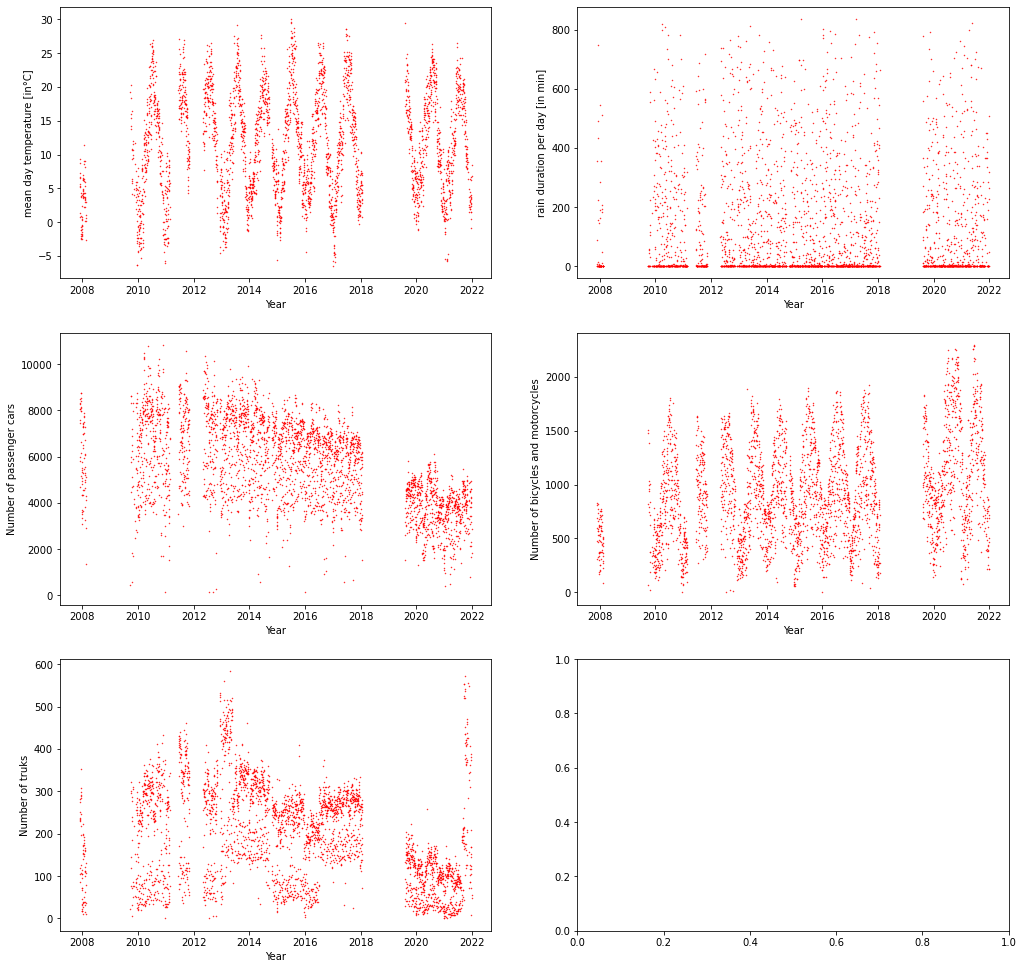

In [6]:
#plot all data according to the date
x=df_weather_traffic_daily['Datum']
y1=df_weather_traffic_daily['Temp']
y2=df_weather_traffic_daily['RainDur']
y3=df_weather_traffic_daily['Personenwagen']
y4=df_weather_traffic_daily['Zweirad']
y5=df_weather_traffic_daily['Lastwagen']


fig, ax = plt.subplots(3,2, figsize=(17,17))
ax[0,0].scatter(x, y1,s=0.2,color='red')
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('mean day temperature [in°C]')

ax[0,1].scatter(x, y2,s=0.2,color='red')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('rain duration per day [in min]')

ax[1,0].scatter(x, y3,s=0.2,color='red')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Number of passenger cars')

ax[1,1].scatter(x, y4,s=0.2,color='red')
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Number of bicycles and motorcycles')

ax[2,0].scatter(x, y5,s=0.2,color='red')
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Number of truks')


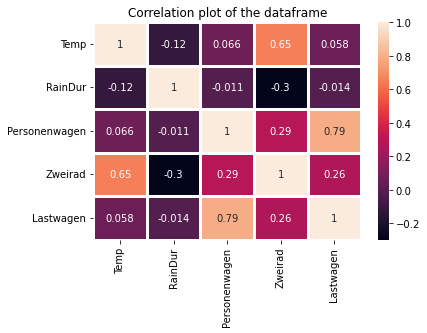

--- COMMENT ---
 we can see that there exist positive correlation between Bicyle/Motorcycle and Temperature and Passenger-cars and trucks and some negative correlations.

Lets try to use a Random Forest classifier to predict the number of bicycles, cars and trucks.


In [7]:
#see correlation between the columns
correlation_plot = sns.heatmap(df_weather_traffic_daily.corr(),annot = True,linewidths=3 )
plt.title("Correlation plot of the dataframe")
plt.show()
print('--- COMMENT ---\n we can see that there exist positive correlation between Bicyle/Motorcycle and Temperature and Passenger-cars and trucks and some negative correlations.\n\nLets try to use a Random Forest classifier to predict the number of bicycles, cars and trucks.')

In [8]:
#construct targets and features of the columns -> Here lets try Bicycle/Motorcycle as a target
print(df_weather_traffic_daily.info())
targets_zweirad = pd.Index(['Zweirad'])
targets_personenwagen=pd.Index(['Personenwagen'])
targets_lastwagen=pd.Index(['Lastwagen'])

features  = pd.Index(['Temp','RainDur'])

#split dataset into a train and test set
df_weather_traffic_daily['is_train'] = np.random.uniform(0, 1, len(df_weather_traffic_daily)) <= 0.75
train_data = df_weather_traffic_daily[df_weather_traffic_daily['is_train']]
test_data  = df_weather_traffic_daily[~df_weather_traffic_daily['is_train']]

print('-----------------------------------------------\nLength of train data:', len(train_data))
print('Length of test data:', len(test_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3385 entries, 0 to 5144
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datum          3385 non-null   datetime64[ns]
 1   Temp           3385 non-null   float64       
 2   RainDur        3385 non-null   float64       
 3   Personenwagen  3385 non-null   float64       
 4   Zweirad        3385 non-null   float64       
 5   Lastwagen      3385 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 185.1 KB
None
-----------------------------------------------
Length of train data: 2554
Length of test data: 831


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
#create the classifier
clf1 = DecisionTreeClassifier()
clf2 = DecisionTreeClassifier()
clf3 = DecisionTreeClassifier()

#fit the classifier
clf1.fit(train_data[features], train_data[targets_zweirad])
clf2.fit(train_data[features], train_data[targets_personenwagen])
clf3.fit(train_data[features], train_data[targets_lastwagen])

#predict on the test set
predict_features1=clf1.predict(test_data[features])
predict_features2=clf2.predict(test_data[features])
predict_features3=clf3.predict(test_data[features])

#Display each feature importance
fi1 = pd.DataFrame(clf1.feature_importances_,
                  columns=['bicycles / motorcycles'],
                  index=['Temp','RainDur'])
fi2 = pd.DataFrame(clf2.feature_importances_,
                  columns=['passenger cars'],
                  index=['Temp','RainDur'])
fi3 = pd.DataFrame(clf3.feature_importances_,
                  columns=['trucks'],
                  index=['Temp','RainDur'])
fi=fi1.join(fi2).join(fi3)
fi

,bicycles / motorcycles,passenger cars,trucks
Temp,0.707867,0.704986,0.693683
RainDur,0.292133,0.295014,0.306317


In [32]:
#predict on the test set bicycle
predict_features1=clf1.predict(test_data[features])
predict_features2=clf2.predict(test_data[features])
predict_features3=clf3.predict(test_data[features])

df1=test_data[targets_zweirad]
blocks=predict_features1
df1['predicted'] = blocks.tolist()

df1['Val_Diff'] = df1['Zweirad'] - df1['predicted']
df1['Val_Diff'] = df1['Val_Diff'].abs()

#predict on the test set targets_personenwagen
predict_features1=clf1.predict(test_data[features])

df2=test_data[targets_personenwagen]
blocks=predict_features2
df2['predicted'] = blocks.tolist()
df2['Val_Diff'] = df2['Personenwagen'] - df2['predicted']
df2['Val_Diff'] = df2['Val_Diff'].abs()

#predict on the test set targets_lastwagen
predict_features1=clf1.predict(test_data[features])

df3=test_data[targets_lastwagen]
blocks=predict_features3
df3['predicted'] = blocks.tolist()

df3['Val_Diff'] = df3['Lastwagen'] - df3['predicted']
df3['Val_Diff'] = df3['Val_Diff'].abs()

df3

C:\Users\claud\AppData\Local\Temp/ipykernel_16664/414444787.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['predicted'] = blocks.tolist()
C:\Users\claud\AppData\Local\Temp/ipykernel_16664/414444787.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Val_Diff'] = df1['Zweirad'] - df1['predicted']
C:\Users\claud\AppData\Local\Temp/ipykernel_16664/414444787.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Lastwagen,predicted,Val_Diff
3,119.0,32.0,87.0
6,235.0,258.0,23.0
7,231.0,13.0,218.0
14,289.0,454.0,165.0
16,299.0,118.0,181.0
...,...,...,...
5113,157.0,36.0,121.0
5118,311.0,424.0,113.0
5122,102.0,254.0,152.0
5131,373.0,119.0,254.0


In [31]:
res_bicycle=(1-(df1['predicted']/df1['Zweirad']))*100
print(res_bicycle.mean())
res_car=(1-(df2['predicted']/df2['Personenwagen']))*100
print(res_car.mean())
res_truck=(1-(df3['predicted']/df3['Lastwagen']))*100
res_truck.median()

-107.28385171352494
-24.42593404328107


-3.571428571428581